In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


prices_1 = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_1.csv', sep=';')
prices_2 = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_2.csv', sep=';')
prices_3 = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_3.csv', sep=';')

df_prices = pd.concat([prices_1, prices_2, prices_3]).reset_index(drop=True)
df_prices['timestamp'] = df_prices['timestamp'] + (df_prices['day'] - 1) * 1000000
df_prices = df_prices.drop(columns=['day', 'profit_and_loss'])
df_coup_prices = df_prices[df_prices['product'] == 'COCONUT_COUPON'].reset_index(drop=True).copy()
df_nut_prices = df_prices[df_prices['product'] == 'COCONUT'].reset_index(drop=True).copy()
premium = 637.63
df_coup_prices['mid_price'] = df_coup_prices['mid_price'] - premium
df_nut_prices['mid_price'] = df_nut_prices['mid_price'] - 10000

In [6]:
df_coup_prices

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price
0,0,COCONUT_COUPON,637.0,39.0,NaN,NaN,NaN,NaN,638,39,NaN,NaN,NaN,NaN,-0.13
1,100,COCONUT_COUPON,637.0,33.0,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,-0.13
2,200,COCONUT_COUPON,637.0,42.0,NaN,NaN,NaN,NaN,638,42,NaN,NaN,NaN,NaN,-0.13
3,300,COCONUT_COUPON,638.0,30.0,NaN,NaN,NaN,NaN,639,30,NaN,NaN,NaN,NaN,0.87
4,400,COCONUT_COUPON,637.0,33.0,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2999500,COCONUT_COUPON,577.0,45.0,NaN,NaN,NaN,NaN,578,45,NaN,NaN,NaN,NaN,-60.13
29996,2999600,COCONUT_COUPON,577.0,30.0,NaN,NaN,NaN,NaN,578,30,NaN,NaN,NaN,NaN,-60.13
29997,2999700,COCONUT_COUPON,575.0,40.0,NaN,NaN,NaN,NaN,576,40,NaN,NaN,NaN,NaN,-62.13
29998,2999800,COCONUT_COUPON,575.0,30.0,NaN,NaN,NaN,NaN,576,44,NaN,NaN,NaN,NaN,-62.13


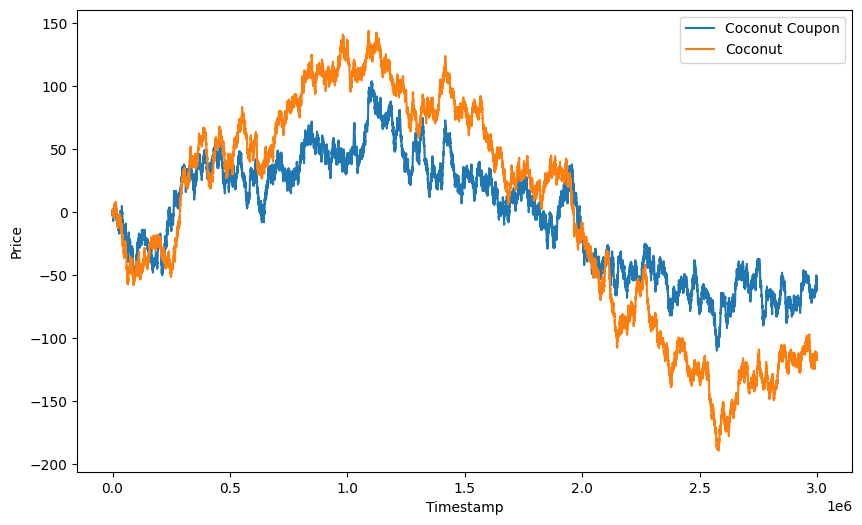

In [7]:
# plot both prices over time
plt.figure(figsize=(10, 6))
plt.plot(df_coup_prices['timestamp'], df_coup_prices['mid_price'], label='Coconut Coupon')
plt.plot(df_nut_prices['timestamp'], df_nut_prices['mid_price'], label='Coconut')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.show()

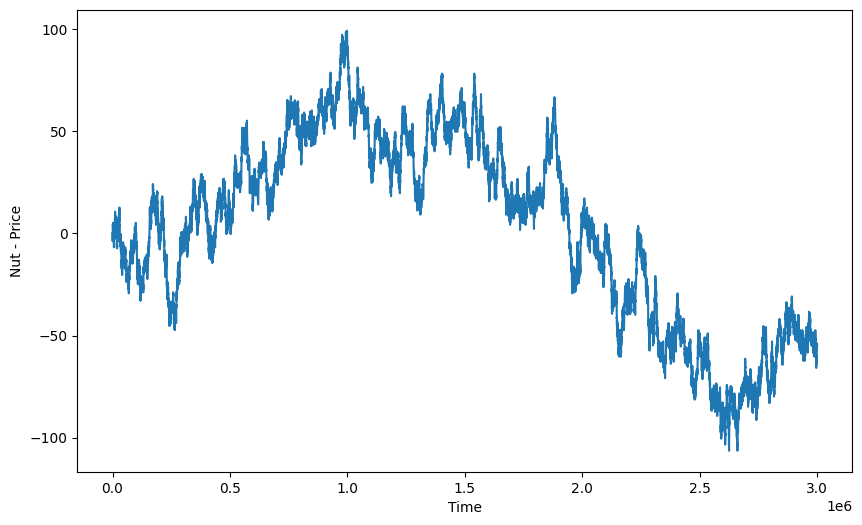

In [8]:
#plot difference between coupon and nut price over time
df_diff = df_nut_prices.copy()
df_diff['diff'] = df_nut_prices['mid_price'] - df_coup_prices['mid_price']
plt.figure(figsize=(10, 6))
plt.plot(df_diff['timestamp'], df_diff['diff'])
plt.xlabel('Time')
plt.ylabel('Nut - Price')
plt.show()


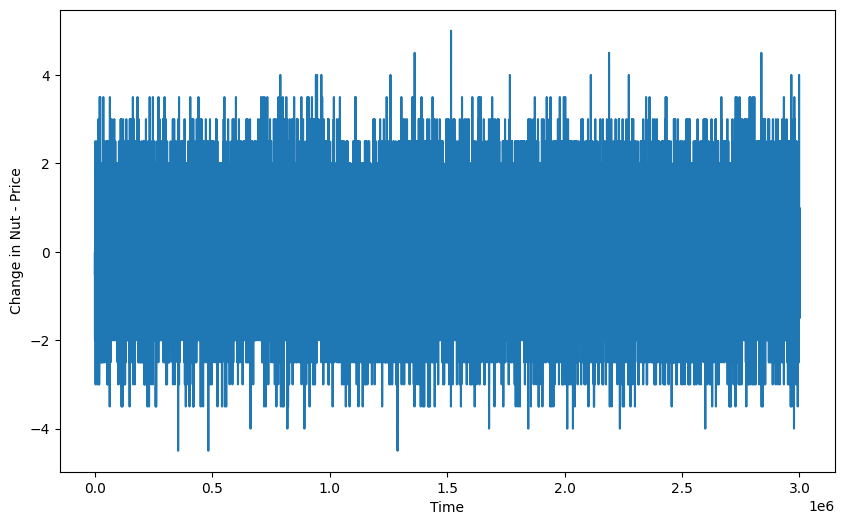

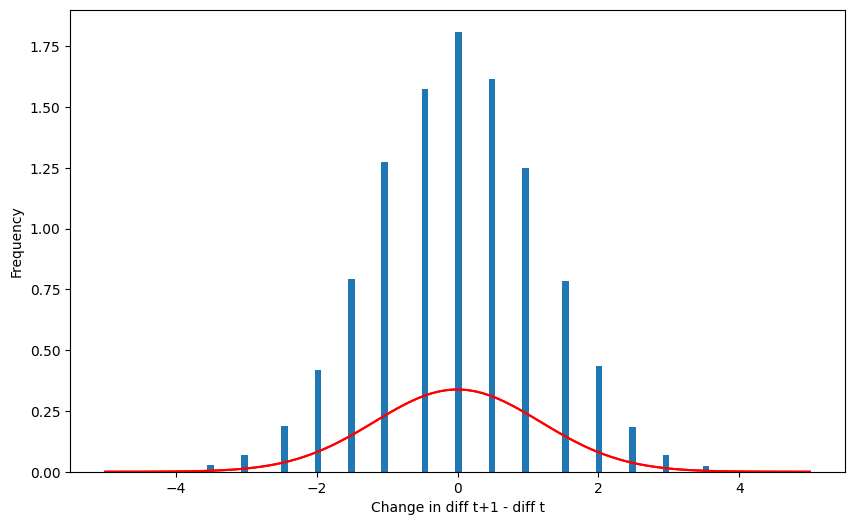

Statistics=0.985, p=0.000


/opt/miniconda3/envs/prosperity/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29999.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
#plot changes in the difference over time
df_diff['diff_change'] = df_diff['diff'].diff()
plt.figure(figsize=(10, 6))
plt.plot(df_diff['timestamp'], df_diff['diff_change'])
plt.xlabel('Time')
plt.ylabel('Change in Nut - Price')
plt.show()


#plot a histogram of the changes and a normal distrithe same mean and stdbution with 
plt.figure(figsize=(10, 6))
plt.hist(df_diff['diff_change'], bins=100, density=True)
mean = df_diff['diff_change'].mean()
std = df_diff['diff_change'].std()
x = np.linspace(-5, 5, 100)
y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2))
plt.plot(x, y, 'r')
plt.plot(x, y, 'r')
plt.xlabel('Change in diff t+1 - diff t')
plt.ylabel('Frequency')
plt.show()

# test for normality
from scipy.stats import shapiro
stat, p = shapiro(df_diff['diff_change'].dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
#issue: since prices are integers, the changes are integers as well, so the normality test is not valid
# They might still be normally distributed with rounding, but we cannot test it with this test

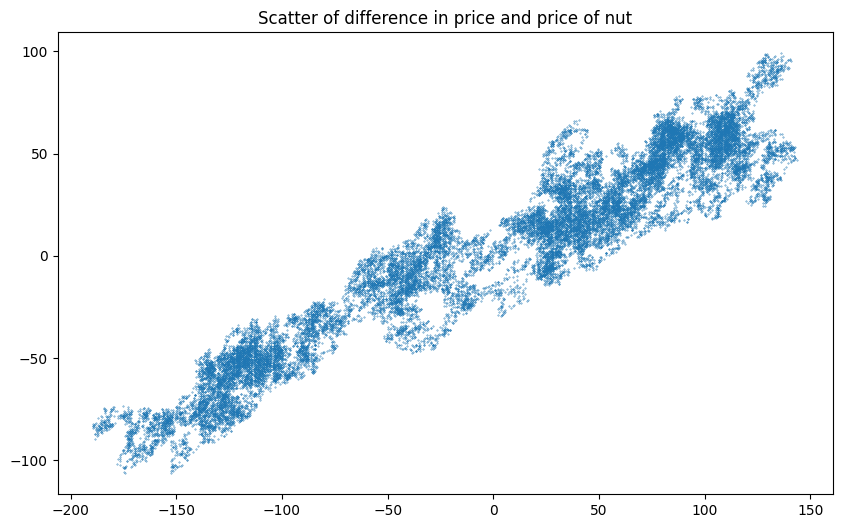

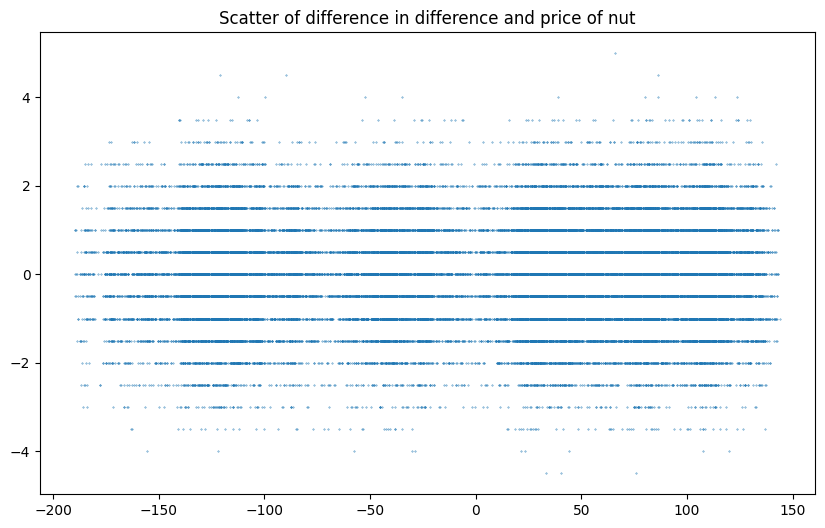

In [10]:
#plot a scatter of the difference in price and the price of the nut
plt.figure(figsize=(10, 6))
plt.title('Scatter of difference in price and price of nut')
plt.scatter(df_diff['mid_price'], df_diff['diff'], s=0.1)
plt.show()

#plot scatter of difference in difference and price of nut
plt.figure(figsize=(10, 6))
plt.title('Scatter of difference in difference and price of nut')
plt.scatter(df_diff['mid_price'], df_diff['diff_change'], s=0.1)
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller
#check if data is stationary
result = adfuller(df_diff['diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#check if differenced data is stationary
result = adfuller(df_diff['diff_change'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# difference itself is not stationary but differenced data is stationary 

ModuleNotFoundError: No module named 'statsmodels'

<Figure size 1000x600 with 0 Axes>

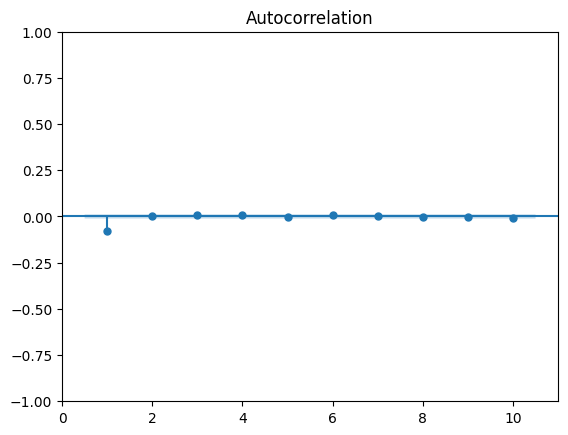

<Figure size 1000x600 with 0 Axes>

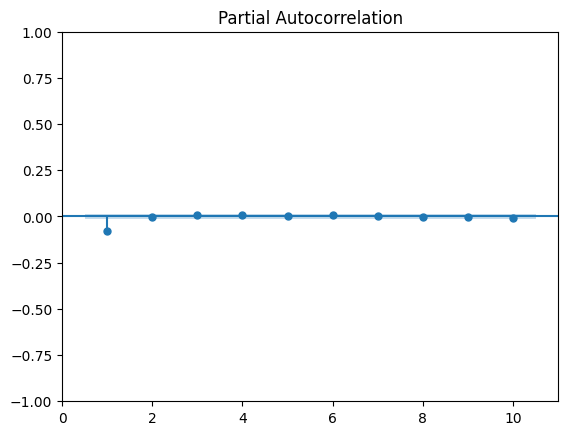

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot acf and pacf
plt.figure(figsize=(10, 6))
plot_acf(df_diff['diff_change'].dropna(), lags=10, zero=False)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(df_diff['diff_change'].dropna(), lags=10, zero=False)
plt.show()

In [ ]:
# fit ARIMA model with d = 1, p = 1, q = 1
model = ARIMA(df_diff['diff'].dropna(), order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                30000
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -47407.733
Date:                Fri, 19 Apr 2024   AIC                          94821.466
Time:                        19:17:06   BIC                          94846.393
Sample:                             0   HQIC                         94829.464
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0524      0.072     -0.724      0.469      -0.194       0.089
ma.L1         -0.0270      0.072     -0.373      0.709      -0.169       0.115
sigma2         1.3809      0.011    121.563      0.0

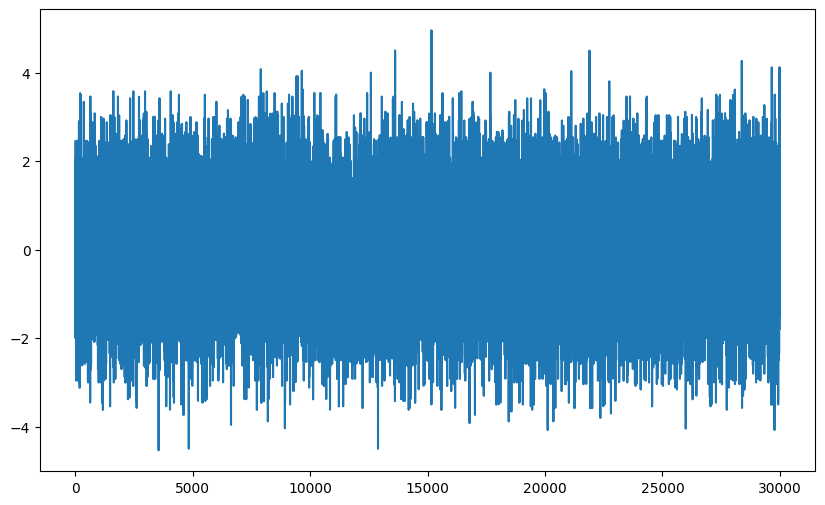

In [ ]:
#plot residuals of model
plt.figure(figsize=(10, 6))
plt.plot(model_fit.resid)
plt.show()


NameError: name 'model_fit' is not defined

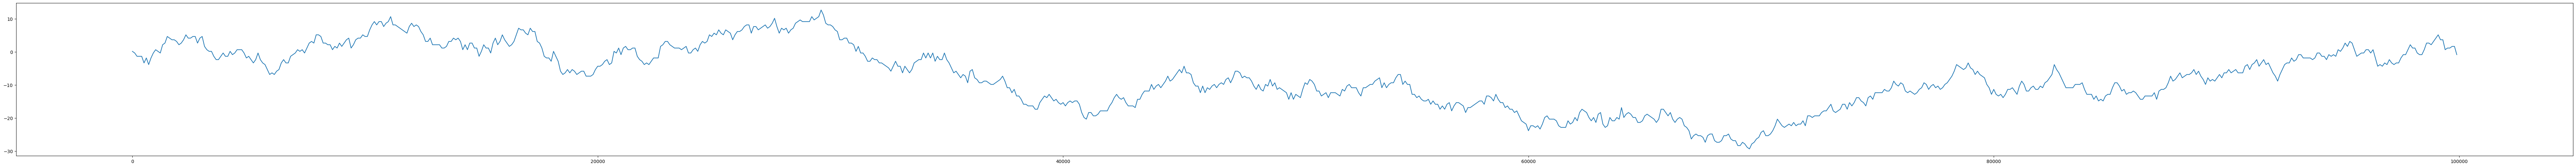

In [12]:
#plot model predictions against actual data
plt.figure(figsize=(100, 6))
plt.plot(df_diff['timestamp'][0:1000], df_diff['diff'][0:1000], label='Actual')
plt.plot(df_diff['timestamp'][0:1000], model_fit.fittedvalues[0:1000], label='Predicted')
plt.legend()
plt.show()

# The model seems to only be able to predict a tiny amount with the rest just being noise. It is not a good model.

In [13]:
#test if diff was already white noise using Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(df_diff['diff_change'].dropna(), lags=10)
print(result)
# Looks like the data was not white noise

#test if residuals of arima model are white noise
result = acorr_ljungbox(model_fit.resid, lags=10)
print(result)
#looks like the residuals are white noise

ModuleNotFoundError: No module named 'statsmodels'

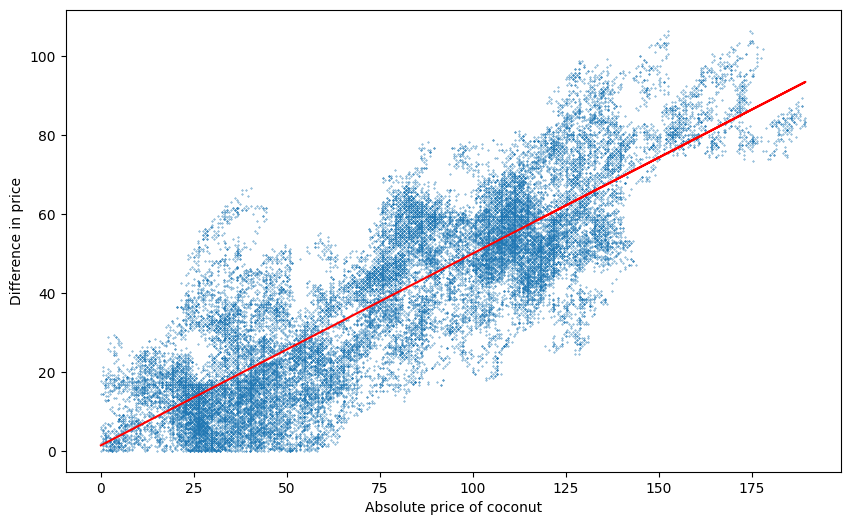

In [14]:
#other idea: plot abs deviation of cocnut price against difference in price
plt.figure(figsize=(10, 6))
plt.scatter(np.abs(df_diff['mid_price']), np.abs(df_diff['diff']), s=0.1)
#plot regression line
from sklearn.linear_model import LinearRegression
X = np.abs(df_diff['mid_price']).values.reshape(-1, 1)
y = np.abs(df_diff['diff']).values
reg = LinearRegression().fit(X, y)
plt.plot(X, reg.predict(X), 'r')
plt.xlabel('Absolute price of coconut')
plt.ylabel('Difference in price')
plt.show()
# Trading idea: -> if the price of the coconut is high, the difference in price is also high. We can model this
# and use it to predict the difference in price. 

#Need to check whether linear regression is predictive using a few past diffs/price values and trade on that

In [16]:
# Black scholes
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [46]:

def binary_search_vol(market_price, S, K, T, r, tolerance=1e-5):
    sigma_low = 0.001
    sigma_high = 1.0
    for i in range(100):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = black_scholes(S, K, T, r, sigma_mid)
        if price_mid > market_price:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid
            
        if abs(price_mid - market_price) < tolerance:
            return sigma_mid
    
    return (sigma_low + sigma_high) / 2

In [47]:
# Calculate implied volatility
from scipy.stats import norm
# join coconut and coupon prices
coup_prices = df_coup_prices['mid_price'].values + premium
coconut_prices = df_nut_prices['mid_price'].values + 10000
K = 10000
T = 250 / 365
r = 0
implied_vol = []
for i in range(len(coup_prices)):
    price = coup_prices[i]
    S = coconut_prices[i]
    sigma = binary_search_vol(price, S, K, T, r)
    implied_vol.append(sigma)
print(implied_vol)
print(max(implied_vol))
print(min(implied_vol))

[0.19329001132398843, 0.19337081022188068, 0.19353235963732, 0.19367466484010218, 0.19353235963732, 0.19385528727620835, 0.19347067841887472, 0.19422088265791532, 0.19347067841887472, 0.19294357828050854, 0.19306695560365913, 0.19300535625964405, 0.19308607700467106, 0.19254001177102326, 0.19245925381034612, 0.19213608054816725, 0.19235905439406636, 0.19243989422917368, 0.1925109612345695, 0.19252071917802094, 0.19296667803451417, 0.1928858084268868, 0.19243989422917368, 0.19205524815618988, 0.19221689805388448, 0.19221689805388448, 0.19199387210607527, 0.1920649837702512, 0.1923168965056538, 0.1919323099777102, 0.19156669598817821, 0.1926207548454404, 0.19278219633549448, 0.19286289475113155, 0.19272034392505882, 0.19324748127907515, 0.19369385322928423, 0.19369385322928423, 0.19338996511697765, 0.19308607700467106, 0.19338996511697765, 0.19338996511697765, 0.19286289475113155, 0.19316678658500308, 0.19322848641127344, 0.19306695560365913, 0.19278219633549448, 0.19278219633549448, 0.1

In [48]:
# get black scholes price for each row
bs_prices = []
for i in range(len(coup_prices)):
    S = coconut_prices[i]
    K = 10000
    T = 250 / 365
    r = 0
    sigma = implied_vol[i]
    price = black_scholes(S, K, T, r, sigma)
    bs_prices.append(price)

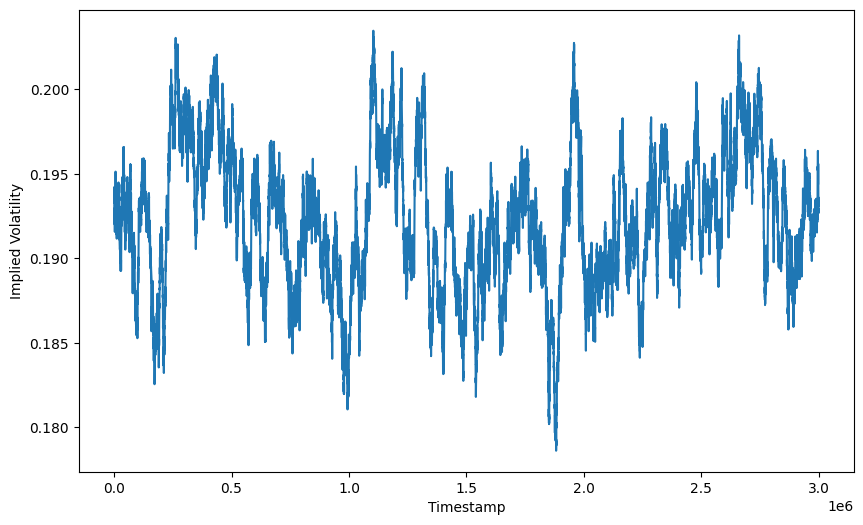

In [55]:
# plot implied volatility over time. Seems mean reverting. 
# Strategy idea: just use mean vol to price the options and trade on that
plt.figure(figsize=(10, 6))
plt.plot(df_coup_prices['timestamp'], implied_vol)
plt.xlabel('Timestamp')
plt.ylabel('Implied Volatility')
plt.show()

In [64]:
# sanity check: black scholes prices are basically same as the actual prices
print(min(coup_prices - bs_prices))
print(max(coup_prices - bs_prices))

-9.999996109399945e-06
9.997320375987329e-06
